Max_camber2.2
position27.5
Free stream Vel5


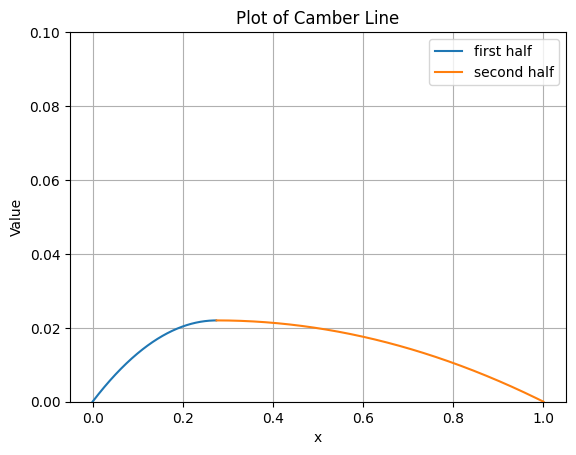

In [1]:
import numpy as np
import matplotlib.pyplot as plt
m=float(input("Max_camber")) #Defining max camber
m=m/100
p=float(input("position"))    #Defination of camber position
p=p/100                      #Converting percentage to position
uinf=float(input("Free stream Vel")) #Defining free stream velocity
def Camber(m,p):                                 #Defining a function to calculate NACA airfoil
    cn=int(1000*p)
    x=np.linspace(0,p,cn,endpoint=False)         #Creating linspace for first part of NACA 4 digit airfoil
    e1=(m)*(2*p*x-x**2)/(p)**2                   #The z coordinate of airfoil
    y=np.linspace(p,1,1000-cn+1)                 #Creating linspace for second part of NACA 4 digit airfoil
    e2=(m)*(1-2*p+(2*p)*y-y**2)/(1-p)**2         #The z coordinate of airfoil
    plt.plot(x,e1)                               #plotting first half
    plt.plot(y,e2)                               #plotting second half (So we can get different colours)
    plt.ylim(0,0.1)
    plt.xlabel('x')
    plt.ylabel('Value')
    plt.title('Plot of Camber Line')
    plt.legend(['first half', 'second half'], loc='best')
    plt.grid(True)
    plt.show()                                    
    return e1, e2, x, y                                     #Ending the define function
e1, e2, x, y=Camber(m,p)

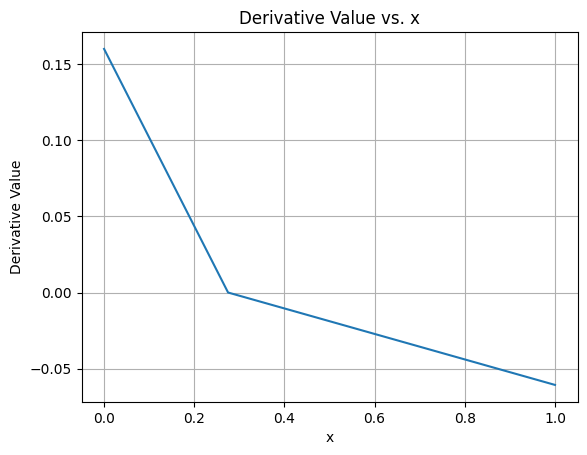

In [2]:
def Slope(m,p):
    n=np.linspace(0,1,1001)
    der=np.array([])
    for i in range(len(n)):
        if n[i]<p:                                     #Deriviative for first half
            der=np.append(der,2*m*(p-n[i])/(p)**2)          
        else:                                          #Deriviative for second half
            der=np.append(der,2*m*(p-n[i])/(1-p)**2)
    
    plt.plot(n,der)                                    #plotting the deriviative
    plt.xlabel('x')
    plt.ylabel('Derivative Value')
    plt.title('Derivative Value vs. x')
    plt.grid(True)
    plt.show()
    return der                                        #returning deriviative array to be used later
der=Slope(m,p)


In [3]:
c5x = np.concatenate((x,y))                                #Concantenating the two halfs
e3=np.concatenate((e1,e2))                                 #Concantenating the two halfs
theta=np.array([])
for i in range(len(c5x)):
    theta=np.append(theta,2*np.arcsin(np.sqrt(c5x[i])))    #Converting x coordinate to theta domain for gamma calculation

In [4]:
aa=float(input("AoA in degrees"))                           #input AoA
aa=aa*np.pi/180                                             #Converting to radians
prec=int(input("How many terms do you want to calculate?")) #Input no of terms to calculate
def Scg(aa,prec,der,theta):
    a=np.zeros([prec])                                      #defining 0 array
    a[0]=aa                                                 #initializing AoA
    for i in range(prec): 
        if i==0:                                            #Calculation of A_0
            for j in range(1000):
                a[i]=a[i]-(der[j])*(theta[j+1]-theta[j])/(np.pi)
        else:                                               #Calculation of A_n where n!=0
            for j in range(1000):
                a[i]=a[i]+2*(np.cos(i*theta[j])*der[j])*(theta[j+1]-theta[j])/np.pi
    return a                                                #returning coefficients
a=Scg(aa,prec,der,theta)
cl=np.pi*(2*a[0]+a[1])                                          #calculating cl
print(cl)
cm=np.pi*(a[0]+a[1]-0.5*a[2])*(-0.5)                            #calculating cm
print(cm)

AoA in degrees3
How many terms do you want to calculate?5000
0.5560359967123842
-0.18581441307219418


In [5]:
def gamma(prec,a,uinf,theta):
    gamma=np.zeros([1001])                                                              #Defining 0 gamma
    for i in range(1000):                                                               #Calculating gamma
        for j in range(prec):                                                           
            if i!=0 and j!=0:                                                           #For summation of A_n n!=0 without 
                gamma[i]=+gamma[i]+2*uinf*a[j]*np.sin(j*theta[i]) 
            elif j==0 and np.sin(theta[i])!=0:                                          #For adding A_0 component
                gamma[i]=+gamma[i]+2*uinf*a[0]*(1+np.cos(theta[i]))/np.sin(theta[i])
            else:                                                                       #in order to avoid inf term and legnthy calcs
                gamma[i]=+0
    gamma[1000]=0                                                                       #Kutta condition
    return gamma
gamma=gamma(prec,a,uinf,theta)

In [6]:
def vx(xx,yy, n):
    u=np.zeros((n,n))                                                              #Horizontal velocity intialisation 
    for j in range(n):
        for i in range(n):                                                         #Converting xx,yy to a grid for calculation
            a=xx[i,j]
            b=yy[i,j]
            vx=0
            for k in range(1000):
                den=((b-e3[k])**2 + (a-c5x[k])**2)                                 #denominator for ease
                dvx=gamma[k]*(b-e3[k])/(2*np.pi*den)*0.001                         #Calc of dvx
                vx=vx+dvx                                                          #Calc of vx
            u[i,j] = vx                                                            #assigning horizontal to grid 
    return u

In [7]:
def vy(xx, yy, n):
    v=np.zeros((n,n))                                                              #Vertical velocity intialisation 
    for j in range(n):
        for i in range(n):                                                         #Converting xx,yy to a grid for calculation
            a=xx[i,j]
            b=yy[i,j]
            vy=0
            for k in range(1001):
                den = ((b-e3[k])**2+(a-c5x[k])**2)                                 #denominator for ease
                dvy = -gamma[k]*(a-c5x[k])/(2*np.pi*den)*0.001                     #Calc of dvy
                vy=vy+dvy                                                          #Calc of vy
            v[i,j]=vy                                                              #assigning vertical to grid 
    return v

In [8]:
X,Y=np.mgrid[-1:2:21j,-1:1:21j,]
u=vx(X,Y,21)                                                                       #induced x velocity
v=vy(X,Y,21)                                                                       #induced y velocity
u=u+uinf*np.cos(aa)                                                                #adding freestream component                                                   
v=v+uinf*np.sin(aa)                                                                #adding freestream component
speed=u*u+v*v                                                                      #speed value
for j in range(21):                                                                #assigning velocity to points near airfoil
    for i in range(21):
        for k in range(len(c5x)):
            if np.sqrt((Y[i,j]-e3[k])**2+(X[i,j]-c5x[k])**2)<0.001 :
                u[i,j]=0
                v[i,j]=0

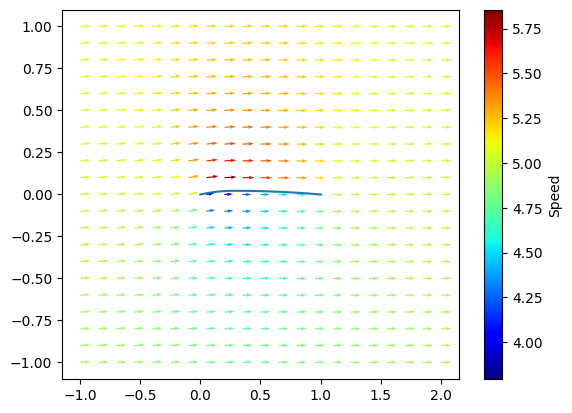

In [9]:
plt.quiver(X,Y,u,v,np.sqrt(speed), cmap='jet')
plt.plot(c5x,e3)  
plt.colorbar(label='Speed')
plt.show()

In [10]:
tau=float(0)
for i in range (1001):                                              #calulating gamma
    tau=tau+gamma[i]*0.001
print(tau)

1.3712651965855762


In [11]:
def vx2(xx,yy, n):                                                          #same as vx defination but only calculating around boundary (top and bottom)
    u=np.zeros((n,n)) 
    for i in range(n):
        a=xx[i,0]
        b=yy[i,0]
        vx=0
        for k in range(1000):
            den=((b-e3[k])**2 + (a-c5x[k])**2)
            dvx=gamma[k]*(b-e3[k])/(2*np.pi*den)*0.001         
            vx=vx+dvx
        u[i,0] = vx
    for i in range(n):
        a=xx[i,n-1]
        b=yy[i,n-1]
        vx=0
        for k in range(1000):
            den=((b-e3[k])**2 + (a-c5x[k])**2)
            dvx=gamma[k]*(b-e3[k])/(2*np.pi*den)*0.001         
            vx=vx+dvx
        u[j,n-1] = vx
    return u

In [12]:
def vy2(xx,yy, n):                                                                       #same as vy but around boundary (left and right)
    v=np.zeros((n,n))
    for i in range(n):
        a=xx[0,i]
        b=yy[0,i]
        vy=0
        for k in range(1000):
            den = ((b-e3[k])**2+(a-c5x[k])**2)
            dvy = -gamma[k]*(a-c5x[k])/(2*np.pi*den)*0.001        
            vy=vy+dvy
        v[0,i] = vy
    for j in range(n):
        a=xx[n-1,j]
        b=yy[n-1,j]
        vy=0
        for k in range(1000):
            den = ((b-e3[k])**2+(a-c5x[k])**2)
            dvy = -gamma[k]*(a-c5x[k])/(2*np.pi*den)*0.001        
            vy=vy+dvy
        v[n-1,j] = vy
    return v

In [13]:
X2,Y2=np.mgrid[-2:4:6001j,-2:4:6001j]
u2=vx2(X2,Y2,6001)
v2=vy2(X2,Y2,6001)    #We didnt add uinf to save time as it would be cancelled out anyways
speed2=np.sqrt(u2*u2+v2*v2)

In [14]:
tau2=float(0)                                 
for i in range(6001):
    tau2 = tau2 + (-u2[i,0]+u2[i,3000])*0.001 + (v2[0,i]-v2[3000,i])*0.000667              #Calculating circulation around bordor
print(tau2)

0.6751896510528624
